# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [14]:
import pandas as pd
import numpy as np
import math
import json
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns; sns.set()
from sklearn.metrics import balanced_accuracy_score

% matplotlib inline

In [15]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

### Explore Dataset

In [16]:
### Rename the offer id and person id, to make joining data much easier
portfolio = portfolio.rename(columns = {'id':'offer_id'})
profile = profile.rename(columns = {'id':'person'})

In [17]:
### Check the portfolio data
print('There are only {} different offer in portfolio data'.format(portfolio.shape[0]))
portfolio

There are only 10 different offer in portfolio data


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [18]:
### Check the profile data
print('There are only {} different persons in portfolio data'.format(len(set(profile.person))))
profile.head()

There are only 17000 different persons in portfolio data


,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [19]:
# extract year from membership start date
profile['became_member_on'] = profile['became_member_on'].apply(str)
profile['year_member'] = profile['became_member_on'].str.slice(stop=4)
profile.head()

,gender,age,person,became_member_on,income,year_member
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017


In [20]:
# Check the aging data in profile
print('There is wide aging ranges in this dataset')
profile.age.describe()

There is wide aging ranges in this dataset


count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [21]:
# Check the income data in profile
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [22]:
profile['income'] = profile['income'].replace(np.nan,64000) # replace nan value with mean of income
# create income bins for each group of income for further visualization
bins = [30000, 45000, 60000, 75000, 90000, 105000, 120000]
labels = ['30K-45K', '45K-60K', '60K-75K', '75K-90K','90K-105K','105K-120K']
profile['IncomeRange'] = pd.cut(profile.income, bins, labels = labels,include_lowest = True)

In [23]:
# create age bins for each age for further visualization
bins = [18, 30, 40, 50, 60, 70, 120]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
profile['agerange'] = pd.cut(profile.age, bins, labels = labels,include_lowest = True)
profile.head()

,gender,age,person,became_member_on,income,year_member,IncomeRange,agerange
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,2017,60K-75K,70+
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017,105K-120K,50-59
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,2018,60K-75K,70+
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017,90K-105K,70+
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,2017,60K-75K,70+


In [24]:
# Check the number of gender in the profile set
profile[['gender','age']].groupby('gender').agg(['count'])

,age
,count
gender,
F,6129
M,8484
O,212


In [25]:
# Chech transcript dataset
print('There are {} events in transcript dataset'.format(transcript.shape[0]))
transcript.head()

There are 306534 events in transcript dataset


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [26]:
# Check time data in transcript
# time (int) - time in hours since start of test. The data begins at time t=0
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [27]:
# Check time data in transcript
transcript.sort_values(by = 'time', ascending = False).head()

,person,event,value,time
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714
305783,016b37032984457fb33ba2767fcc8c9f,transaction,{'amount': 1.72},714
305777,dd2f15d3224349b3a54cbb4a91e89e0c,transaction,{'amount': 17.51},714
305778,fac959096aa4492db3b1114bc6f2cd27,transaction,{'amount': 2.7},714
305779,ec70faa2792f4ee19d67dca4957d285f,transaction,{'amount': 6.87},714


In [28]:
## Explode the value in json types to new colunms, for the convenience of joining data
transcript[['offer id', 'amount', 'offer_id', 'reward']]= transcript['value'].apply(pd.Series)
transcript['offer'] = np.where(len(transcript['offer id']) > 2, transcript['offer id'], transcript['offer_id'])
transcript = transcript.drop(['offer id','offer_id','value'], axis = 1)
transcript = transcript.rename(columns = {'offer':'offer_id'})

In [29]:
## check the dimension of dataset
transcript.shape

(306534, 6)

In [30]:
# types of event
set(transcript.event)

{'offer completed', 'offer received', 'offer viewed', 'transaction'}

In [31]:
## check the event types and counts
transcript.groupby(['event'])['time'].agg(['count'])

,count
event,
offer completed,33579
offer received,76277
offer viewed,57725
transaction,138953


In [32]:
# Find Offer Complete
offer_comp_length = len(transcript[transcript['event'] =='offer completed'])
# Find Offer View
offer_view_length = len(transcript[transcript['event'] =='offer viewed'])
# Find Offer Receive
offer_recei_length = len(transcript[transcript['event'] =='offer received'])
print('The ratio of event times BTW view and receive', offer_view_length/offer_recei_length)
print('The ratio of event times BTW complete and view', offer_comp_length/offer_view_length)
print('The ratio of event times BTW complete and receive', offer_comp_length/offer_recei_length)

The ratio of event times BTW view and receive 0.7567812053436815
The ratio of event times BTW complete and view 0.5817063663923776
The ratio of event times BTW complete and receive 0.4402244451145168


In [75]:
print('There are {} records, and {} unique person id in transcripts'.format(transcript.shape[0], len(set(transcript.person))))

There are 306534 records, and 17000 unique person id in transcripts


In [76]:
transcript.head()

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


# Data Cleaning

#### Explore Customer who viewed and completed offer

In [77]:
# Find Offer Complete
offer_comp_df = transcript[transcript['event'] =='offer completed']
# Find Offer View
offer_view_df = transcript[transcript['event'] =='offer viewed']

In [78]:
# check offer completed related data
print('There are {} person complete the offer'.format(len(set(offer_comp_df.person))))
print('There are {} completed offer record'.format(len(offer_comp_df)))
offer_comp_df.head()

There are 12774 person complete the offer
There are 33579 completed offer record


,person,event,time,amount,reward,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,NaN,2.0,NaN
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,NaN,2.0,NaN
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,NaN,5.0,NaN
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,NaN,10.0,NaN
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,NaN,10.0,NaN


In [79]:
# check offer viewed related data
print('There are {} person view the offer'.format(len(set(offer_view_df.person))))
print('There are {} viewed offer record'.format(len(offer_view_df)))
offer_view_df.head()

There are 16834 person view the offer
There are 57725 viewed offer record


,person,event,time,amount,reward,offer_id
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837


In [80]:
### Select the person who view and complete the event
set_comp = set(offer_comp_df.person)
set_view = set(offer_view_df.person)
ppo_view_comp = set_comp.intersection(set_view)
offer_view_df_ppo = offer_view_df[offer_view_df['person'].isin(ppo_view_comp)]

In [81]:
offer_view_df_ppo.head()

,person,event,time,amount,reward,offer_id
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [82]:
# Select the people who completed the offer also viewed the offer
offer_comp_df_ppo = offer_comp_df[offer_comp_df['person'].isin(ppo_view_comp)]
print('There are {} times offer completed by people who viewed offer'.format(offer_comp_df_ppo.shape[0]))

There are 33466 times offer completed by people who viewed offer


In [83]:
# Merge people who view and complete offer with customer profiles
offer_comp_ppo_profile = pd.merge(offer_comp_df_ppo, profile, on = 'person', how = 'inner')
# Merge people who view the offer with customer profiles
offer_view_profile = pd.merge(offer_view_df, profile, on = 'person', how = 'inner')

offer_view_profile.head()

,person,event,time,amount,reward,offer_id,gender,age,became_member_on,income,year_member,IncomeRange,agerange
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,M,65,20180209,53000.0,2018,45K-60K,60-69
1,389bc3fa690240e798340f5a15918d5c,offer viewed,192,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,65,20180209,53000.0,2018,45K-60K,60-69
2,389bc3fa690240e798340f5a15918d5c,offer viewed,354,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,M,65,20180209,53000.0,2018,45K-60K,60-69
3,389bc3fa690240e798340f5a15918d5c,offer viewed,438,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,65,20180209,53000.0,2018,45K-60K,60-69
4,389bc3fa690240e798340f5a15918d5c,offer viewed,504,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,M,65,20180209,53000.0,2018,45K-60K,60-69


In [84]:
offer_comp_ppo_profile.head()

,person,event,time,amount,reward,offer_id,gender,age,became_member_on,income,year_member,IncomeRange,agerange
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,NaN,2.0,NaN,M,42,20160117,96000.0,2016,90K-105K,40-49
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,354,NaN,3.0,NaN,M,42,20160117,96000.0,2016,90K-105K,40-49
2,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,474,NaN,5.0,NaN,M,42,20160117,96000.0,2016,90K-105K,40-49
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,540,NaN,10.0,NaN,M,42,20160117,96000.0,2016,90K-105K,40-49
4,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,NaN,2.0,NaN,F,39,20171217,67000.0,2017,60K-75K,30-39


# Analysis

In [85]:
## Create a function to group selected columns and make bar plot
def groupby_count(offer_view_profile, columns, titlename):
    """
    Input: 
    offer_view_profile: a dataframe using to group by feature of people
    columns: the columns used to group by and count
    titlename: a part of title name we want to show above the bar plot
    Output:
    Bar plot: y axis is response rate, x axis is selected columns used to group by 
    """
    ## Group by people who view the offer and count
    person_view = offer_view_profile[['person', columns]].groupby(columns).agg('count')
    ## Group by people who complete the offer and count
    person_comp = offer_comp_ppo_profile[['person', columns]].groupby(columns).agg('count')
    respon_rate = person_comp/person_view
    respon_rate = respon_rate.reset_index()
    ### Responsive Rate Bar Plot for each group
    height = respon_rate['person']
    bars = respon_rate[columns]
    y_pos = np.arange(len(bars))

    # Create bars
    plt.bar(y_pos, height)
    # Create names on the x-axis
    plt.xticks(y_pos, bars)
    plt.title('Responsive Rate for Each '+ titlename)
    plt.xlabel(titlename)
    plt.ylabel('Responsive Rate')
    # Show graphic
    plt.show()
    return None

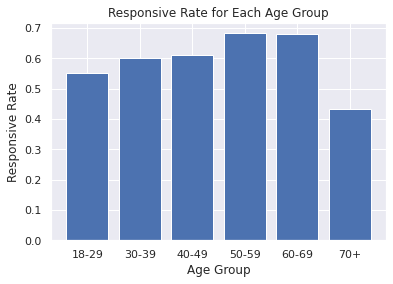

In [86]:
## Group by agerange and create bar plot
groupby_count(offer_view_profile, 'agerange', 'Age Group')

In [87]:
offer_view_profile.columns

Index(['person', 'event', 'time', 'amount', 'reward', 'offer_id', 'gender',
       'age', 'became_member_on', 'income', 'year_member', 'IncomeRange',
       'agerange'],
      dtype='object')

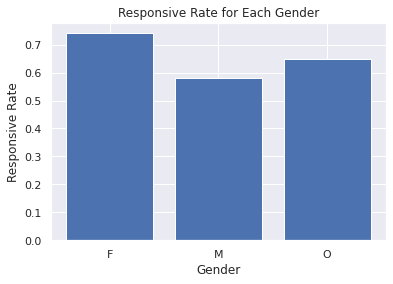

In [88]:
## Group by gender and create bar plot
groupby_count(offer_view_profile, 'gender', 'Gender')

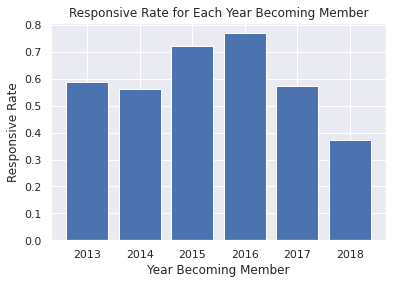

In [89]:
## Group by year and create bar plot
groupby_count(offer_view_profile, 'year_member', 'Year Becoming Member')

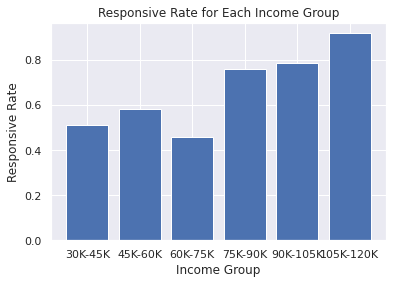

In [90]:
## Group by incomerange and create bar plot
groupby_count(offer_view_profile, 'IncomeRange', 'Income Group')

# Build Model

Here I choose if the person has responded to the offer when they view offer as the predicted label. The reason why we choose this, is to figure out what kind of customer will respond to offer and what kind of customers never repond to offer. This metric is to help target towards to customer who will respond to the offer.

Event = 1; It means the person has reponded to the offer challenge 

Event = 0; It means the person has not responded to the offer challenge

# Pre-processing the data for build model

### select the unique customer who veiw and complete offer, then label them as one

In [91]:
offer_view_and_comp = offer_comp_ppo_profile
offer_view_and_comp = offer_view_and_comp.drop_duplicates(subset = ['person'], keep = 'first')

In [92]:
offer_view_and_comp['event'] = offer_view_and_comp['event'].replace('offer completed', 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
offer_view_and_comp.head()

,person,event,time,amount,reward,offer_id,gender,age,became_member_on,income,year_member,IncomeRange,agerange
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0,NaN,2.0,NaN,M,42,20160117,96000.0,2016,90K-105K,40-49
4,fe97aa22dd3e48c8b143116a8403dd52,1,0,NaN,2.0,NaN,F,39,20171217,67000.0,2017,60K-75K,30-39
5,629fc02d56414d91bca360decdfa9288,1,0,NaN,5.0,NaN,M,52,20180605,72000.0,2018,60K-75K,50-59
8,676506bad68e4161b9bbaffeb039626b,1,0,NaN,10.0,NaN,M,37,20170515,92000.0,2017,90K-105K,30-39
10,8f7dd3b2afe14c078eb4f6e6fe4ba97d,1,0,NaN,10.0,NaN,M,48,20150903,62000.0,2015,60K-75K,40-49


### select the unique customer who view and not complete offer, then label them as zero

In [94]:
offer_view_not_comp = offer_view_df[~offer_view_df['person'].isin(ppo_view_comp)]
offer_view_not_comp = offer_view_not_comp.drop_duplicates(subset = ['person'], keep = 'first')

In [95]:
offer_view_not_comp = pd.merge(offer_view_not_comp, profile, on = 'person', how = 'inner')

In [96]:
offer_view_not_comp.head()

,person,event,time,amount,reward,offer_id,gender,age,became_member_on,income,year_member,IncomeRange,agerange
0,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,F,20,20160711,30000.0,2016,30K-45K,18-29
1,e528ceb341964128aaf58a59733ec2af,offer viewed,0,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,F,46,20180629,36000.0,2018,30K-45K,40-49
2,262ad0fb526a4d53b572007da60cce24,offer viewed,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,M,40,20180227,53000.0,2018,45K-60K,30-39
3,182e68952b474700b171e21b85c258ac,offer viewed,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,None,118,20170823,64000.0,2017,60K-75K,70+
4,c099206f76b1414db7552f163520053c,offer viewed,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,118,20150730,64000.0,2015,60K-75K,70+


In [97]:
offer_view_not_comp['event'] = offer_view_not_comp['event'].replace('offer viewed', 0)
offer_view_not_comp.head()

,person,event,time,amount,reward,offer_id,gender,age,became_member_on,income,year_member,IncomeRange,agerange
0,02c083884c7d45b39cc68e1314fec56c,0,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,F,20,20160711,30000.0,2016,30K-45K,18-29
1,e528ceb341964128aaf58a59733ec2af,0,0,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,F,46,20180629,36000.0,2018,30K-45K,40-49
2,262ad0fb526a4d53b572007da60cce24,0,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,M,40,20180227,53000.0,2018,45K-60K,30-39
3,182e68952b474700b171e21b85c258ac,0,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,None,118,20170823,64000.0,2017,60K-75K,70+
4,c099206f76b1414db7552f163520053c,0,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,118,20150730,64000.0,2015,60K-75K,70+


In [98]:
print('The length of record for customer view but not complete is {}, for customer view and complete is {}'.format(len(offer_view_not_comp),len(offer_view_and_comp)))

The length of record for customer view but not complete is 4133, for customer view and complete is 12701


### combine two dataset together

In [99]:
offer_view_and_comp.columns

Index(['person', 'event', 'time', 'amount', 'reward', 'offer_id', 'gender',
       'age', 'became_member_on', 'income', 'year_member', 'IncomeRange',
       'agerange'],
      dtype='object')

In [100]:
offer_view_not_comp.columns

Index(['person', 'event', 'time', 'amount', 'reward', 'offer_id', 'gender',
       'age', 'became_member_on', 'income', 'year_member', 'IncomeRange',
       'agerange'],
      dtype='object')

In [101]:
df = pd.concat([offer_view_and_comp, offer_view_not_comp])

In [102]:
df.head()

,person,event,time,amount,reward,offer_id,gender,age,became_member_on,income,year_member,IncomeRange,agerange
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0,NaN,2.0,NaN,M,42,20160117,96000.0,2016,90K-105K,40-49
4,fe97aa22dd3e48c8b143116a8403dd52,1,0,NaN,2.0,NaN,F,39,20171217,67000.0,2017,60K-75K,30-39
5,629fc02d56414d91bca360decdfa9288,1,0,NaN,5.0,NaN,M,52,20180605,72000.0,2018,60K-75K,50-59
8,676506bad68e4161b9bbaffeb039626b,1,0,NaN,10.0,NaN,M,37,20170515,92000.0,2017,90K-105K,30-39
10,8f7dd3b2afe14c078eb4f6e6fe4ba97d,1,0,NaN,10.0,NaN,M,48,20150903,62000.0,2015,60K-75K,40-49


In [103]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(how='all', axis=1)
    Y = df['event']
    
    #Drop respondent and expected salary columns
    df = df.drop(['event','person','reward','offer_id','became_member_on','IncomeRange','agerange'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        #df[col].fillna((0),inplace=True)
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, Y
    
#Use the function to create X and y
X, Y = clean_data(df)  

In [104]:
X.columns

Index(['time', 'age', 'income', 'gender_M', 'gender_O', 'year_member_2014',
       'year_member_2015', 'year_member_2016', 'year_member_2017',
       'year_member_2018'],
      dtype='object')

## Split Data into Train and Test Dataset

In [105]:
# Use 20% of dataset as test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# Use 10% of dataset as validation dataset; Use 70% of dataset as training dataset
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [106]:
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (12120, 10) (12120,)
validation: (1347, 10) (1347,)
test: (3367, 10) (3367,)


## Check the Size of Each Category

From the plot below, we can notice that this class of 1 and 0 is not balance. 

To measure the prediction result accurately, we have to weight the accuracy rate based on the size of data

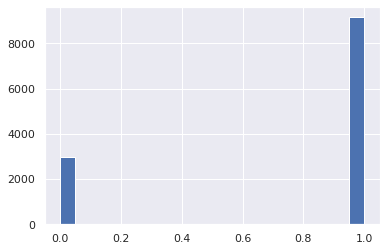

In [107]:
plt.hist(Y_train, bins=20);

(array([ 332.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1015.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

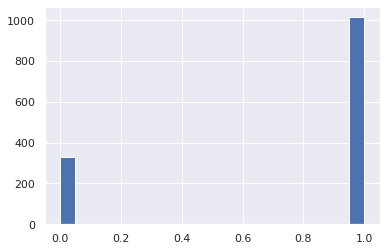

In [108]:
plt.hist(Y_val, bins=20)

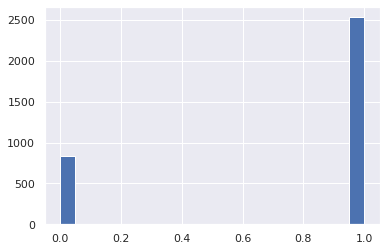

In [109]:
plt.hist(Y_test, bins=20);

## Metrics to measure the performance of model

Accuracy rate is common for classifiction model. Since the size of label is imbalanced, here I will use a built-in module in sklearn for balanced accuracy 

sklearn.metrics.balanced_accuracy_score(y_true, y_pred, *, sample_weight=None, adjusted=False)[source]

Here is the document link:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


## Feature Normalization

The reason to normalize the feature is because the some feature(like income) are much larger than other feature (like the dummy variable). The result is not that accurate if we don't normalize them

In [111]:
#apply feature normalization to training, validation and test sets
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

# Fit Classification Model

## build a LogisticRegression classifier as the baseline model

In [114]:
#set class_weight='balanced'
LR=LogisticRegression(class_weight='balanced', solver='newton-cg', random_state=0)
LR.fit(X_train, Y_train)
Y_val_pred=LR.predict(X_val)
confusion_val=confusion_matrix(Y_val, Y_val_pred)

Y_test_pred=LR.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)

acc_val = balanced_accuracy_score(Y_val, Y_val_pred)
acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.7321146655587869
classification accuracy on test set is  0.7499983432125203


In [143]:
# Model Evaluation and Validation
cv = cross_validate(LR, X_test, Y_test, cv=10)
print('The performance of each validation fold:')
print(cv['test_score'])
print('The mean of performance of 10validation fold:')
print(cv['test_score'].mean())

The performance of each validation fold:
[0.75074184 0.71810089 0.74480712 0.72403561 0.7537092  0.73293769
 0.7537092  0.7172619  0.74702381 0.76785714]
The mean of performance of 10validation fold:
0.7410184400169564


## Decision Tree Classifier

### Fit Model

In [135]:
#set class_weight='balanced'
dt=DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=0)
dt.fit(X_train, Y_train)
Y_val_pred=dt.predict(X_val)
confusion_val=confusion_matrix(Y_val, Y_val_pred)
Y_test_pred=dt.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)
acc_val = balanced_accuracy_score(Y_val, Y_val_pred)
acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.7303534334381863
classification accuracy on test set is  0.7182583187299352


### Tune parameter using validation dataset

In [116]:
max_depth_list = np.arange(1,15)
#train a DecisionTreeClassifier with max_depth in max_depth_list
#inside a for loop:
#   create a model with a max_depth in max_depth_list
#   set class_weight to 'balanced'
#   set random_state=0 so that the result is reproducible
#   train the model on the training set
#   record the accuracy on the training set into a list acc_train_list
#   record the accuracy on the validation set into a list acc_val_list
acc_train_list=[]
acc_val_list=[]
for i in max_depth_list:
    dt=DecisionTreeClassifier(class_weight='balanced', max_depth=i, random_state=0)
    dt.fit(X_train, Y_train)
    Y_val_pred=dt.predict(X_val)
    confusion_val=confusion_matrix(Y_val, Y_val_pred)
    
    acc_val = balanced_accuracy_score(Y_val, Y_val_pred)
    Y_train_pred=dt.predict(X_train)
    confusion_train=confusion_matrix(Y_train, Y_train_pred)
    
    acc_train = balanced_accuracy_score(Y_train, Y_train_pred)
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)


    print('classification accuracy on validation set is ', acc_val, 'with max_depth:',i)
    print('classification accuracy on train set is ', acc_train,'with max_depth:',i)

print(acc_train_list)
print(acc_val_list)

classification accuracy on validation set is  0.6426508991631551 with max_depth: 1
classification accuracy on train set is  0.6382710084059142 with max_depth: 1
classification accuracy on validation set is  0.7054276218173186 with max_depth: 2
classification accuracy on train set is  0.7128968749105892 with max_depth: 2
classification accuracy on validation set is  0.7209789898510297 with max_depth: 3
classification accuracy on train set is  0.7233446420402644 with max_depth: 3
classification accuracy on validation set is  0.7272315864442993 with max_depth: 4
classification accuracy on train set is  0.7402065128739967 with max_depth: 4
classification accuracy on validation set is  0.7514659623716541 with max_depth: 5
classification accuracy on train set is  0.7687809651385386 with max_depth: 5
classification accuracy on validation set is  0.7636699507389162 with max_depth: 6
classification accuracy on train set is  0.7797969293386433 with max_depth: 6
classification accuracy on validat

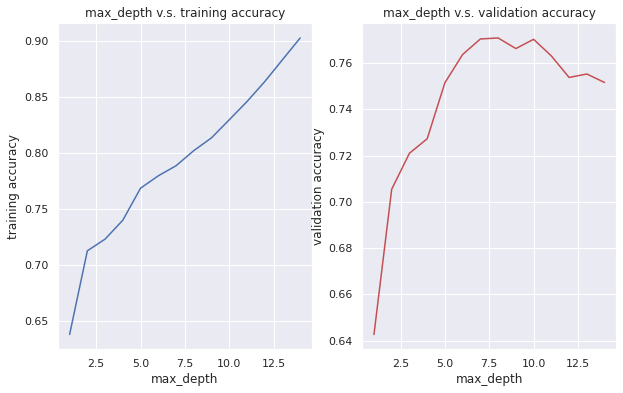

In [117]:
#plot max_depth vs acc_train using max_depth_list and acc_train_list
#plot max_depth vs acc_val using max_depth_list and acc_val_list
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(max_depth_list, acc_train_list, 'b')
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('training accuracy')
ax[0].set_title('max_depth v.s. training accuracy')
ax[0].grid(True)
ax[1].plot(max_depth_list, acc_val_list, 'r')
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('validation accuracy')
ax[1].set_title('max_depth v.s. validation accuracy')
ax[1].grid(True)

In [138]:
#find the best max_depth using np.argmax, max_depth_list and acc_val_list
max_depth_best=np.argmax(acc_val_list)
max_depth_best

7

In [139]:
#now, we use the best max_depth to build a DecisionTreeClassifier
#train it on the training set and evaluate it on the testing set
dt=DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth_best, random_state=0)
dt.fit(X_train, Y_train)
Y_train_pred=dt.predict(X_train)
confusion_train=confusion_matrix(Y_train, Y_train_pred)
Y_test_pred=dt.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)

acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
acc_val = balanced_accuracy_score(Y_val, Y_val_pred)
acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
print('classification accuracy on train set is ', acc_train, 'with max_depth:',max_depth_best)
print('classification accuracy on test set is ', acc_test,'with max_depth:',max_depth_best)

classification accuracy on train set is  0.8999863266944885 with max_depth: 7
classification accuracy on test set is  0.7702199077690078 with max_depth: 7


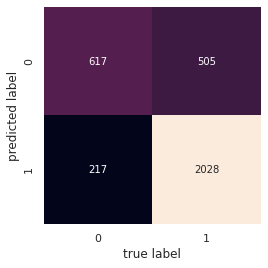

In [140]:
sns.heatmap(confusion_test.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [145]:
# Model Evaluation and Validation
cv = cross_validate(dt, X_test, Y_test, cv=10)
print('The performance of each validation fold:')
print(cv['test_score'])
print('The mean of performance of 10 validation fold:')
print(cv['test_score'].mean())

The performance of each validation fold:
[0.73293769 0.7388724  0.76557864 0.6884273  0.77151335 0.74777448
 0.7388724  0.74404762 0.76785714 0.75      ]
The mean of performance of 10 validation fold:
0.7445881023032359


## Random Forest Classifier

### Fit Model

In [122]:
#set class_weight='balanced'
RF=RandomForestClassifier(n_estimators=20, class_weight='balanced', max_depth=20, random_state=0)
RF.fit(X_train, Y_train)
Y_val_pred=RF.predict(X_val)
confusion_val=confusion_matrix(Y_val, Y_val_pred)

Y_test_pred=RF.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)

acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
acc_val = balanced_accuracy_score(Y_val, Y_val_pred)
acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.7403035788474093
classification accuracy on test set is  0.7330108278162311


In [123]:
#train a RandomForestClassifier with max_depth in max_depth_list
#inside a for loop: 
#   create a model with a max_depth in max_depth_list
#   set class_weight to 'balanced', n_estimators=20
#   set random_state=0 so that the result is reproducible
#   train the model on the training set
#   record the accuracy on the training set into a list acc_train_list
#   record the accuracy on the validation set into a list acc_val_list
acc_train_list=[]
acc_val_list=[]
for i in max_depth_list:
    RF=RandomForestClassifier(n_estimators=20, class_weight='balanced', max_depth=i, random_state=0)
    RF.fit(X_train, Y_train)
    Y_val_pred=RF.predict(X_val)
    confusion_val=confusion_matrix(Y_val, Y_val_pred)
    Y_train_pred=RF.predict(X_train)
    confusion_train=confusion_matrix(Y_train, Y_train_pred)
    acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
    acc_val = balanced_accuracy_score(Y_val, Y_val_pred)
    acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    print('classification accuracy on validation set is ', acc_val, 'with max_depth:',i)
    print('classification accuracy on train set is ', acc_train,'with max_depth:',i)

classification accuracy on validation set is  0.7247240192296278 with max_depth: 1
classification accuracy on train set is  0.734562873840332 with max_depth: 1
classification accuracy on validation set is  0.7348581518190991 with max_depth: 2
classification accuracy on train set is  0.7512406706809998 with max_depth: 2
classification accuracy on validation set is  0.7303682711140127 with max_depth: 3
classification accuracy on train set is  0.7557767629623413 with max_depth: 3
classification accuracy on validation set is  0.753535818149445 with max_depth: 4
classification accuracy on train set is  0.7691641449928284 with max_depth: 4
classification accuracy on validation set is  0.7637960709834412 with max_depth: 5
classification accuracy on train set is  0.7773782014846802 with max_depth: 5
classification accuracy on validation set is  0.7731838684788415 with max_depth: 6
classification accuracy on train set is  0.7875620126724243 with max_depth: 6
classification accuracy on validatio

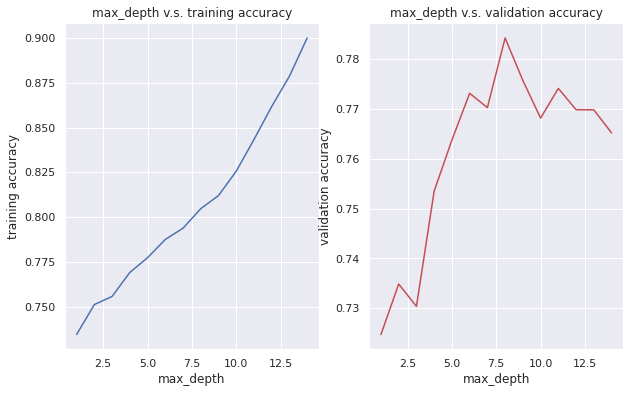

In [124]:
#plot max_depth vs acc_train using max_depth_list and acc_train_list
#plot max_depth vs acc_val using max_depth_list and acc_val_list
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(max_depth_list, acc_train_list, 'b')
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('training accuracy')
ax[0].set_title('max_depth v.s. training accuracy')
ax[0].grid(True)
ax[1].plot(max_depth_list, acc_val_list, 'r')
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('validation accuracy')
ax[1].set_title('max_depth v.s. validation accuracy')
ax[1].grid(True)

In [125]:
#find the best max_depth using np.argmax, max_depth_list and acc_val_list
max_depth_best=np.argmax(acc_val_list)
max_depth_best

7

In [130]:
#now, we use the best max_depth to build a RandomForestClassifier
#train it on the training set and evaluate it on the testing set
RF=RandomForestClassifier(n_estimators=20, class_weight='balanced', max_depth=i, random_state=0)
RF.fit(X_train, Y_train)
Y_train_pred=RF.predict(X_train)
confusion_train=confusion_matrix(Y_train, Y_train_pred)

Y_test_pred=RF.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)

acc_test = balanced_accuracy_score(Y_test, Y_test_pred)
acc_val = balanced_accuracy_score(Y_val, Y_val_pred)
acc_test = balanced_accuracy_score(Y_test, Y_test_pred)


print('classification accuracy on train set is ', acc_train, 'with max_depth:',max_depth_best)
print('classification accuracy on test set is ', acc_test,'with max_depth:',max_depth_best)

classification accuracy on train set is  0.8999863266944885 with max_depth: 7
classification accuracy on test set is  0.7625707566595756 with max_depth: 7


Model Evaluation and Validation for Random Forest model

Set a fold of 10, and using cross validation to check the performance on test dataset of final model. Here we can tell the average test scores are quite stable

In [146]:

cv = cross_validate(RF, X_test, Y_test, cv=10)
print('The performance of each validation fold:')
print(cv['test_score'])
print('The mean of performance of 10 validation fold:')
print(cv['test_score'].mean())

The performance of each validation fold:
[0.78931751 0.82492582 0.81602374 0.78931751 0.82789318 0.82492582
 0.83086053 0.7827381  0.83035714 0.82142857]
The mean of performance of 10 validation fold:
0.81377879044793


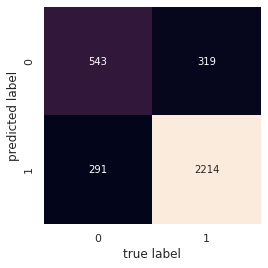

In [128]:
sns.heatmap(confusion_test.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

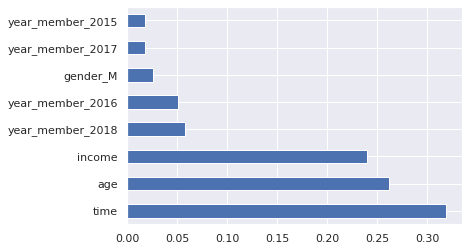

In [129]:
# Using the feature importance plot to predict the data
feat_importances = pd.Series(RF.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')

## Model Evaluation and Validation
After fitting three models, we need to check final model’s qualities to validate the robustness of the model’s solution.
The approach that I have taken here to demonstrate that your tuned model is robust is performing a k-fold cross validation. Here the k = 10 fold.

In this case, I have document how the model performs across each individual validation fold, and then take a mean of each performance across 10 folds.

Though the decision tree has the best performance in the individual test result, the performance among cross validation seems unstable, and even lower than the result of random forest. In the mean time, the random forest has relatively stable performance, with accuracy rate of 0.81 across validation.

### Logistic Regression
classification accuracy on test set:
0.7499983310699463 

The performance of each validation fold:
[0.75074184 0.71810089 0.74480712 0.72403561 0.7537092 0.73293769 0.7537092 0.7172619 0.74702381 0.76785714]

The mean of performance of 10 validation fold:
0.7410184400169564
### Random Forest
classification accuracy on test set is
0.7623733282089233 with max_depth: 7

The performance of each validation fold:
[0.78931751 0.82492582 0.81602374 0.78931751 0.82789318 0.82492582 0.83086053 0.7827381 0.83035714 0.82142857]

The mean of performance of 10 validation fold:
0.81377879044793
### Decision Tree
classification accuracy on test set is :
0.7702199220657349 with max_depth: 7

The performance of each validation fold:
[0.73293769 0.7388724 0.76557864 0.6884273 0.77151335 0.74777448 0.7388724 0.74404762 0.76785714 0.75 ]

The mean of performance of 10 validation fold:
0.7445881023032359

# Final Model

After comparing the weighted classification accuracy rate and the result of cross validation, here I choose random forest as our final model with performance of accuracy rate around 0.76 and cross validation result around 0.81



#  Future improvements

In the future, there are some ways to improve the models.

First, currently I am using the classical supervised machine learning model. Some advanced models could be good supervised learning approaches to try here, such as XGBoost and LightGBM models. Additionally, some deep learning models can also good options.

Second, currently I am comparing the individual performance of three models. I could also try combining them all together into a custom ensemble model.

Third, currently I am only tuning one parameter for each model, and in the future I will use grid search to tune the portfolio of different parameter.